In [3]:
import numpy as np
import matplotlib.pyplot as plt
import meshio

# load a simplicial mesh
mesh = meshio.read("/home/aspadotto/meshes/square.msh")

In [4]:
# parse the raw data structures
Nnode = mesh.points.shape[0]
Nelements = mesh.cells[1].__dict__['data'].shape[0]
elements = mesh.cells[1].__dict__['data']
barycenters = np.zeros((Nelements,2))
edge_barycenters = np.zeros((Nelements,3,2))
nodes_primal   = mesh.points
boundary_edges = mesh.cells[0].__dict__['data']

for i in range (Nelements):
    x = 0.
    y = 0.
    triangle = elements[i,:]
    for j in range (3):
        #calculate element barycenter
        x = x + 1/3*nodes_primal[elements[i,j],0]
        y = y + 1/3*nodes_primal[elements[i,j],1]
        #calculate edge barycenter
        start = j
        if j==2:
            end = 0
        else:
            end = j+1
        xx  = 0.5*(nodes_primal[triangle[start], 0]+nodes_primal[triangle[end],0])
        yy  = 0.5*(nodes_primal[triangle[start], 1]+nodes_primal[triangle[end],1])
        edge_barycenters [i,j,:] = [xx,yy]
    barycenters[i,:] = [x,y]

IndexError: list index out of range

In [8]:
#need to build node2node connectivity (neighbours)
#need to build node2element connectivity (near_cells)

neighbours = [[]]*Nnode
near_cells = [[]]*Nnode
for i in range (Nelements):
    elem = elements[i]
    for j in range(3):
        # fill near_cells
        if (near_cells[elem[j]]==[]):
            near_cells[elem[j]] = [i]
        else:
            near_cells[elem[j]].append(i)
        # fill neighbours 
        for k in (1,2):
            ind = (j+k)%3 #cyclic index
            if (neighbours[elem[j]]==[]):
                neighbours[elem[j]] =[elem[ind]]
            elif not(elem[ind] in neighbours[elem[j]]):
                neighbours[elem[j]].append(elem[ind])

In [308]:
#need to mark nodes on the boundary and the interface (primal)
bnd_marker = np.zeros(Nnode)
for i in range (Nnode):
    if nodes_primal[i,1]==0.:
        bnd_marker[i] = 1
    elif nodes_primal [i,0]==1.:
        bnd_marker[i] = 2
    elif nodes_primal[i,1]==1.:
        bnd_marker[i] = 3
    elif nodes_primal[i,0]==0.:
        bnd_marker[i] = 4
    else:
        bnd_marker[i] = 0
    if nodes_primal[i,0]==0.5:
        bnd_marker[i] = -1 #interface

for i in range (Nnode):
    x,y = nodes_primal[i,0], nodes_primal[i,1]
    if y==0.:
        bnd_marker[i] = 1
    elif y==1.:
        bnd_marker[i] = 3 #need the point (0.,0.5) and (1.,1.5) to be recognized on the boundary

In [420]:
def erone (p1,p2,p3):
    area = 0.
    a = np.linalg.norm(p2-p1)
    b = np.linalg.norm(p3-p2)
    c = np.linalg.norm(p1-p3)
    p = 0.5*(a+b+c)
    area = np.sqrt(p*(p-a)*(p-b)*(p-c))
    return area 

In [379]:
# must count the exact number of dual_nodes
#all the barycenters + 0.5* all the internal edge_bary + all the border edge_bary + all the border primal nodes

Nnode_dual = 0 
for k in range(Nelements):
    Nnode_dual = Nnode_dual +1 #barycenter
    for j in range (3):
        if (bnd_marker[elements[k][j]] > 0  and bnd_marker[elements[k][(j+1)%3]] > 0):
            Nnode_dual = Nnode_dual +2
        else:
            Nnode_dual = Nnode_dual +0.5
Nnode_dual = int (Nnode_dual)
print (Nnode_dual)

3693


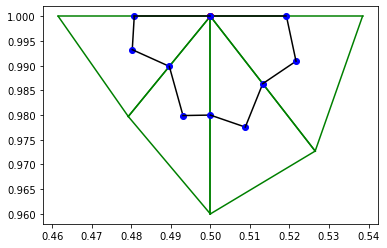

In [424]:
# BUILD THE DUAL MESH (we use this to define cells)
cells = [[]]*Nnode
m_T   = np.zeros(Nnode)
for k in range (Nnode):
    #if the central node is on the boundary the first cell is the one such that 
    #the next to the central node is still on the boundary
    if (bnd_marker[k]>0):
        elem_0 = [el for el in near_cells[k] if 
                  bnd_marker[
                             elements 
                               [el]
                               [
                                 ([n  for n,x in enumerate(elements[el]) if x==k][0] + 1)  %  3
                               ]
                             ]>0
                   ][0]
    #the starting element is the first in near_cells
    else:
        elem_0 = near_cells[k][0]
    explored = 0
    my_k = 5
    if (k ==my_k):
        fig,ax = plt.subplots()
    while (explored<len(near_cells[k])):
        if (k ==my_k):
            ax.plot(nodes_primal[k][0], nodes_primal[k][1], 'ro')
            for j in range(3):
                ax.plot([nodes_primal[elements[elem_0][j]][0], nodes_primal[elements[elem_0][(j+1)%3]][0]],
                   [nodes_primal[elements[elem_0][j]][1], nodes_primal[elements[elem_0][(j+1)%3]][1]], 'g')
        #the position of the central node in the internal numeration
        local_idx = [n for n,x in enumerate(elements[elem_0]) if x == k][0]
        #store barycenter of edge on the right and barycenter of the element
        #need to act differently at the very beginning
        if (explored ==0):
            cells [k] = [0.5*(nodes_primal[k]+ nodes_primal[  elements[elem_0][(local_idx+1)%3]])[0:2]]
        else:
            cells [k].append(0.5*(nodes_primal[k]+ nodes_primal[  elements[elem_0][(local_idx+1)%3]])[0:2])
        cells [k].append(np.array(barycenters[elem_0]))
        #area calculation
        m_T[k] = m_T[k] + erone (nodes_primal[k][0:2], 
                                 0.5*(nodes_primal[k]+ nodes_primal[  elements[elem_0][(local_idx+1)%3]])[0:2],
                                 barycenters[elem_0]) \
                        +  erone (nodes_primal[k][0:2], 
                                 0.5*(nodes_primal[k]+ nodes_primal[  elements[elem_0][(local_idx+2)%3]])[0:2],
                                 barycenters[elem_0]) 
        
        if (explored+1 < len(near_cells[k])):
              elem_1 = [m for m in near_cells[k] if  
                          ((elements[elem_0][(local_idx+2)%3] in elements[m]) 
                             and 
                          (m!=elem_0)) 
                       ][0]
        elem_0 = elem_1
        explored = explored +1
    # we must add a node id on border
    if (bnd_marker[k]>0):
        cells [k].append(0.5*(nodes_primal[k]+ nodes_primal[  elements[elem_0][(local_idx+2)%3]])[0:2])
        cells[k].append(nodes_primal[k][0:2])
    if (k ==my_k):
        for j in range(len(cells[k])):
            ax.plot (cells[k][j][0], cells[k][j][1], 'bo')
            ax.plot ([cells[k][j][0], cells[k][(j+1)%len(cells[k])][0]], 
                     [cells[k][j][1], cells[k][(j+1)%len(cells[k])][1]],'k')

# DUAL NODES
nodes_dual = []
nodes_dual.append(np.array([0.,0.]))
nodes_dual.append(np.array([0.,1.]))
nodes_dual.append(np.array([1.,0.]))
nodes_dual.append(np.array([1.,1.]))
for k in range(Nelements):
    nodes_dual.append(np.array(barycenters[k,:]))
    pos_bary= [m for m,x in enumerate (nodes_dual) if np.linalg.norm(x-barycenters[k,:])<1e-6][0]
    for j in range(3):
        edge_bary = 0.5*(nodes_primal[elements[k][j]] + nodes_primal[elements[k][(j+1)%3]])[0:2]
        if (not np.any(1e-6>np.linalg.norm(edge_bary-nodes_dual, axis = 1))):
            nodes_dual.append(edge_bary)
        #don't forget connections n the border
        if (bnd_marker[elements[k][j]] >0 
               and not 
            np.any(1e-6>np.linalg.norm(nodes_primal[elements[k][j]][0:2]-nodes_dual, axis = 1))):
                    nodes_dual.append(nodes_primal[elements[k][j]][0:2])

In [434]:
# NEIGHBOURS: remember that with polygons we have generalized neighbours
#loop over cells
   #loop over nodes (idx i)
        # loop over nodes of same cell (idx j)
            #add j to neighbours of i if not already present
#in the meanwhile build for each cell the list of indexes of nodes  
neighs = [[]]*Nnode_dual
cells_idx = []
for k in range(Nnode):
    cell_idx = []
    for i in range(len(cells[k])):
        idx_i = [n for n,x in enumerate(nodes_dual) if np.linalg.norm(x-cells[k][i])<1e-6][0]
        cell_idx.append(idx_i)
        for jj in range (len(cells[k])-1):
            j = (i+jj+1)%len(cells[k])
            idx_j = [n for n,x in enumerate(nodes_dual) if np.linalg.norm(x-cells[k][j])<1e-6][0]
            if neighs[idx_i] ==[]:
                 neighs[idx_i]=[idx_j]
            else:
                 if (not idx_j in neighs[idx_i]):
                    neighs[idx_i].append(idx_j)
    cells_idx.append(cell_idx)
    

In [435]:
#need to mark nodes on the boundary and the interface (dual)
bnd_marker_dual = np.zeros(Nnode_dual)
for i in range (Nnode_dual):
    if nodes_dual[i][1]==0.:
        bnd_marker_dual[i] = 1
    elif nodes_dual [i][0]==1.:
        bnd_marker_dual[i] = 2
    elif nodes_dual[i][1]==1.:
        bnd_marker_dual[i] = 3
    elif nodes_dual[i][0]==0.:
        bnd_marker_dual[i] = 4
    else:
        bnd_marker_dual[i] = 0
    if nodes_dual[i][0]==0.5:
        bnd_marker_dual[i] = -1 #interface

for i in range (Nnode_dual):
    x,y = nodes_dual[i][0], nodes_dual[i][1]
    if y==0.:
        bnd_marker_dual[i] = 1
    elif y==1.:
        bnd_marker_dual[i] = 3 #need the point (0.,0.5) and (1.,1.5) to be recognized on the boundary


In [436]:
print (Nnode_dual, len(nodes_dual))

3693 3693


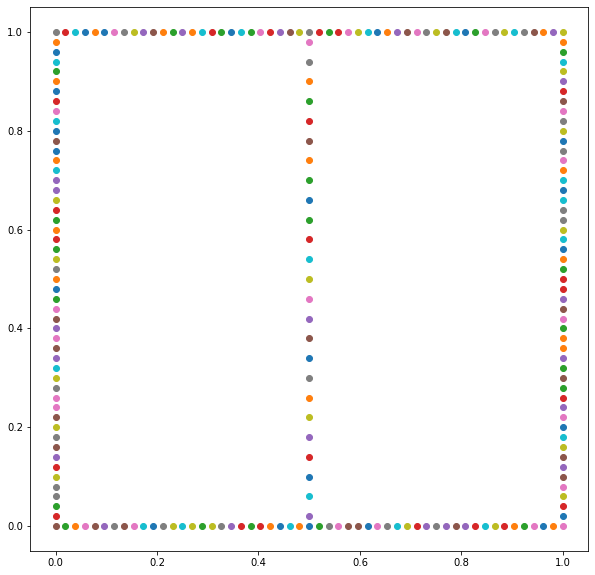

In [437]:
fig, ax = plt.subplots(figsize = (10,10))
from itertools import compress

colors = ['g','r','b','y', 'o', 'k']
for i in range(6):
    mask = (bnd_marker_dual == i-1)
    bnd = list(compress(nodes_dual,mask))
    if i!=1:
        for j in range(len(bnd)):
            pt = ax.scatter(bnd[j][0], bnd[j][1])

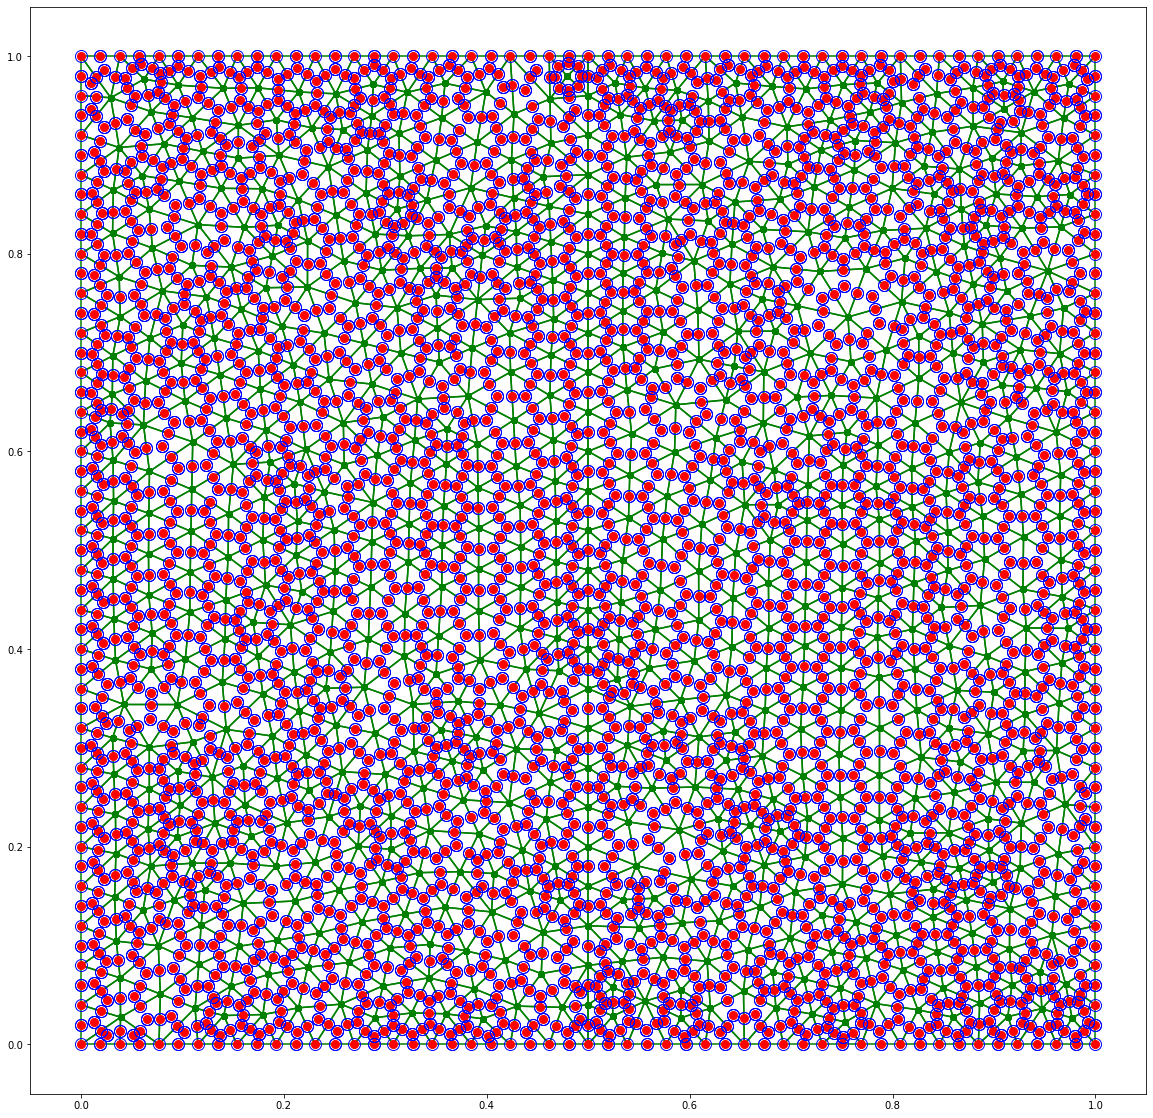

In [428]:
#a look at the primal mesh with barycenters
fig, ax  = plt.subplots(figsize = (20,20))
for i in range (Nelements):
    triangle = elements[i,:]
    for j in range(3): 
        start = j
        if j==2:
            end = 0
        else:
            end = j+1
        xx  = (nodes_primal[triangle[start], 0], nodes_primal[triangle[end],0])
        yy  = (nodes_primal[triangle[start], 1], nodes_primal[triangle[end],1])
        edge= ax.plot(xx,yy, 'go-')

i = 0
ax.plot (nodes_dual[i][0] , nodes_dual[i][1] , 'ro' )
for k in neighs[i]:
    ax.plot (nodes_dual[k][0] , nodes_dual[k][1] , 'ro' )

#for k in range(len(cells[i])):
#    ax.plot (cells[i][k][0], cells[i][k][1], 'bo')
#    if k ==0:
#        ax.plot (cells[i][k][0], cells[i][k][1], 'go', mfc='none', ms = 10 )
#        m = [n for n,x in enumerate(nodes_dual) if np.linalg.norm(x-cells[i][k])==0][0]
#        for j in neighs[m]:
#            ax.plot (nodes_dual[j][0], nodes_dual[j][1], 'ro', mfc='none', ms = 10)

for k in range(Nnode_dual):
    ax.plot (nodes_dual[k][0], nodes_dual[k][1], 'ro', ms=8)
for k in range(Nnode):
    for i in range(len(cells[k])):
        ax.plot (cells[k][i][0], cells[k][i][1], 'bo', ms=12, mfc='none') 

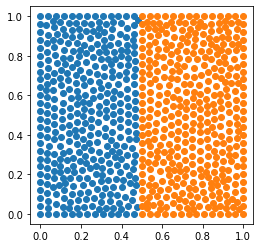

In [438]:
#interface along diagonal, sigma selected according to where barycenter falls
sigma1 = 0.1
sigma2 = 1
mask = (nodes_primal[:,0]<0.5)
sigma = np.zeros((Nnode))
sigma[mask] = sigma1
sigma[mask[:]==False] = sigma2

fig, ax = plt.subplots(figsize = (4,4))
pt1 = ax.scatter(nodes_primal[mask,0], nodes_primal[mask,1])
pt2= ax.scatter(nodes_primal[mask[:] == False,0], nodes_primal[mask[:]==False,1])

In [461]:
normal = []
rot = np.array([[0,1],[-1,0]])

#fig, ax = plt.subplots(figsize = (20,20))

#calculate normals
for k in range(Nnode):
    normal_k = []
    cell = cells[k]
    size = len(cell)
    #loop over the edges
    for i in range(size):
        j = (i+1)%size
        edge = cell[j]-cell[i]
        edge_bary = 0.5*(cell[j]+cell[i])
        #ax.plot([nodes[elem[j]][0],nodes[elem[i]][0]], [nodes[elem[j]][1],nodes[elem[i]][1]],'r-')
        normal_k.append(np.dot(rot,edge))
        #ax.arrow(edge_bary[0], edge_bary[1], -normal[k,i,0], -normal[k,i,1])
    normal.append(normal_k)
omega = [[]]*Nnode_dual

#calculate omega_ij
#loop over cells
for k in range(Nnode):
    cell = cells[k]
    size = len(cell) 
    #loop over nodes
    for i in range(size):
       #loop over neighbours 
       for jj in range(size-1):
            j = (i+1 + jj)%size
            e_avg_i = +0.5*(normal[k][i][:] + normal[k][(i-1)%size][:])
            e_avg_j = +0.5*(normal[k][j][:] + normal[k][(j-1)%size][:])
            #global indexes of i and j 
            global_i = cells_idx[k][i]
            global_j = cells_idx[k][j]
            #index local to neighs
            #print (k, global_i, nodes_dual[global_i], global_j, nodes_dual[global_j], neighs[global_i])
            index_j = [n for n,x in enumerate(neighs[global_i]) if x == global_j][0]
            if (omega[global_i]==[]):
                omega[global_i]=[0.]
            while (len(omega[global_i])<(index_j+1)):
                omega[global_i].append(0.)
            #print (sigma[k],m_T[k], e_avg_i,e_avg_j)
            omega[global_i][index_j] = omega[global_i][index_j] - sigma[k]/m_T[k]*np.dot(e_avg_i,e_avg_j)

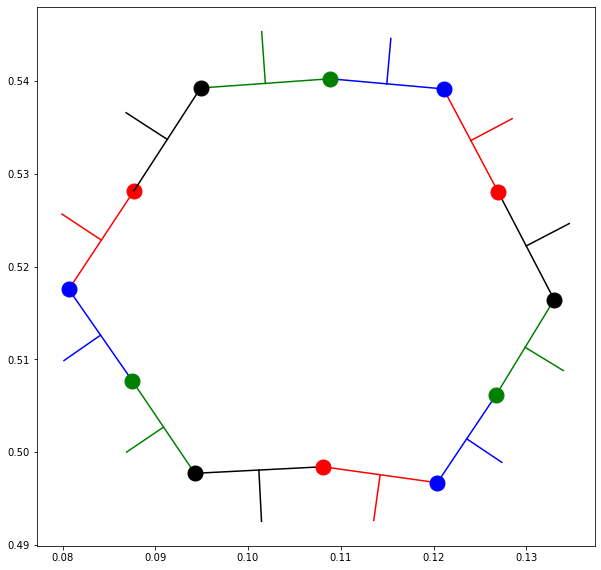

In [433]:
#check ordering
fig,ax = plt.subplots(figsize = (10,10))
plt.gca().set_aspect('equal', adjustable='box')
i = 220
colors = ['r', 'b', 'g', 'k']
cell = cells[i]
for n in range(len(cell)):
        dot = ax.plot(cell[n][0], cell[n][1], colors[n%4], markersize=15, marker ='o')
        tri = ax.plot([cell[n][0], cell[(n+1)%len(cell)][0]], 
                      [cell[n][1], cell[(n+1)%len(cell)][1]],colors[n%4])
        edge_bary = 0.5*(cell[(n)%len(cell)]+cell[(n+1)%len(cell)])
        norm = ax.plot([edge_bary[0],edge_bary[0] + 0.4*normal[i][n][0]], 
                       [edge_bary[1],edge_bary[1] + 0.4*normal[i][n][1]], colors[n%4])
    

In [306]:
print (cells[:4])

[[array([0.01923077, 0.        ]), array([0.02584725, 0.00915858]), array([0.01954011, 0.01373787]), array([0.01302674, 0.02249192]), array([0.  , 0.02]), array([0., 0., 0.])], [array([1.  , 0.02]), array([0.99230992, 0.02219835]), array([0.98846488, 0.01329752]), array([0.97948941, 0.00886502]), array([0.98076923, 0.        ]), array([1., 0., 0.])], [array([0.98076923, 1.        ]), array([0.97839327, 0.99055512]), array([0.98682067, 0.98583268]), array([0.99121378, 0.97722179]), array([1.  , 0.98]), array([1., 1., 0.])], [array([0.  , 0.98]), array([0.0097914 , 0.97258424]), array([0.0146871 , 0.97887636]), array([0.02261192, 0.98591757]), array([0.01923077, 1.        ]), array([0., 1., 0.])]]


# need to build $\omega_{ij}$ (for the moment without stabilization):

- loop over the elements
- calculate the normals and the averages
- from each element 6 contributions to the omega_ij


In [9]:
#quadrature over a segment: Simpson 3/8 formula, doe = 3
#we try, by exploiting div theorem, to transform every surface integrals into a sum of edge integrals    

def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/3
    mid2 = a + (b-a)*2/3
    if   (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/8*(fun(mid1[0],mid1[1]) + 
                                       fun(mid2[0],mid2[1])*2  +
                                       fun(b[0], b[1]))
    elif (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/8*(fun(a[0], a[1]) + 
                                       2*fun(mid1[0],mid1[1])+
                                       fun(mid2[0],mid2[1]))
    else: 
        return  np.linalg.norm(b-a)/8*(fun(a[0], a[1]) + 3*fun(mid1[0],mid1[1]) +
                                       3*fun(mid2[0],mid2[1]) + fun(b[0], b[1]))

In [443]:
#quadrature over a segment: Boole formula
#we try, by exploiting div theorem, to transform every surface integrals into a sum of edge integrals    

def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/4
    mid2 = a + (b-a)*2/4
    mid3 = a + (b-a)*3/4
    if   (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        24*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                        8*fun(mid3[0],mid3[1]))
    elif (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/90*(8*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                       24*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))
    else: 
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        32*fun(mid1[0],mid1[1]) +
                                        12*fun(mid2[0],mid2[1]) + 
                                        32*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))

In [11]:
#let's test integration by flux
elem = 0
x_T = np.array(barycenters[elem,:])
fun = lambda x,y: x*y
pot = lambda x,y: 0.25*np.array([x**2*y, x*(y**2)])
#fun = lambda x,y: 1.
#pot = lambda x,y: 0.5*np.array([x-x_T[0], y-x_T[1]])
#fun = lambda x,y : x+y 
#pot = lambda x,y : np.array([y,x])
integ = 0.
for k in range(4):
                    n = normal[elem,k,:]
                    n = n/np.linalg.norm(n)
                    start = np.array(nodes[elements[elem][k]])
                    end = np.array(nodes[elements[elem][(k+1)%4]])
                    #print (simpson(start, end, lambda x,y: np.dot(-n,pot(x,y))))
                    #print(-n)
                    integ = integ + simpson(start, end, lambda x,y: np.dot(-n,pot(x,y)))
                    
print (((1./element_per_row)**4)/4, integ)

1.5625000000000003e-06 1.5625000000000005e-06


In [465]:
#RECONSTRUCTION
REC = []
S = [] 
#loop over elements
for t in range(Nnode):
    node_per_elem = len(cells[t])
    dim_basis     = 3 #dimension of basis of R,c2(T) 
    V = np.zeros ((node_per_elem, dim_basis)) #evaluation matrix
    M = np.zeros ((dim_basis, dim_basis))     #the mass matrix to invert
    B1 = np.zeros ((dim_basis,node_per_elem))  #the rhs matrix (part 1)
    B2 = np.zeros ((dim_basis,node_per_elem))  #the rhs matrix (part 2)
    x_T = np.array(nodes_primal[t])[0:2]
    #define the psi_i (for edge contribution of B)
    psi = [None for _ in range(dim_basis)]
    psi [0] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])
    psi [1] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(x-x_T[0])
    psi [2] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(y-x_T[1])
    #define the phi_i (for V)
    phi = [None for _ in range(dim_basis)]
    phi [0] = lambda x,y: 2.
    phi [1] = lambda x,y: 3*(x - x_T[0])
    phi [2] = lambda x,y: 3*(y - x_T[1])
    #define the csi_ij (integrated phi_i*phi_j, for M)
    csi = [[None for _ in range(dim_basis)] for _ in range (dim_basis)]
    csi [0][0] = lambda x,y: np.array([2*(x-x_T[0]), 
                                       2*(y-x_T[1])])
    csi [0][1] = csi[1][0] = lambda x,y: np.array([0., 
                                                   6*(y-x_T[1])*(x-x_T[0])])
    csi [0][2] = csi[2][0] = lambda x,y: np.array([6*(x-x_T[0])*(y-x_T[1]),
                                                   0.])
    csi [1][1] = lambda x,y: np.array([0., 
                                       9*(y-x_T[1])*((x-x_T[0])**2)])
    csi [1][2] = csi[2][1] = lambda x,y: np.array([(9/4)*((x-x_T[0])**2)*(y-x_T[1]), 
                                                   (9/4)*(x-x_T[0])*((y-x_T[1])**2)])
    csi [2][2] = lambda x,y: np.array([9*(x-x_T[0])*((y-x_T[1])**2),
                                       0.])
    #define the chi_iN  (for cell contribution in B)
    chi_fac = [None for _ in range (dim_basis)]
        #visualization
        #if (t == -1):
        #  fig,ax = plt.subplots(figsize=(4,4))
         #   plt.gca().set_aspect('equal', adjustable='box')
          #  start1 = end2 = np.array(nodes[elements[t][j]]) #dx
           # start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
            #end1 = np.array(nodes[elements[t][(j+1)%node_per_elem]])
           # ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
           # ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'r')
            #ax.plot ([start1[0],start1[0]+ e_avg[0] ],
             #        [start1[1],start1[1]+ e_avg[1]])
    chi_fac[0] = lambda  x,y: np.array([(x-x_T[0])*(y-x_T[1]),
                                        (x-x_T[0])*(y-x_T[1])]) 
    chi_fac[1] = lambda  x,y: np.array([0.5*((x-x_T[0])**2)*(y-x_T[1]),
                                        (y-x_T[1])*((x-x_T[0])**2)]) 
    chi_fac[2] = lambda  x,y: np.array([(x-x_T[0])*((y-x_T[1])**2),
                                        0.5*((y-x_T[1])**2)*(x-x_T[0])]) 
    #fill V  
    for i in range(node_per_elem):
        xx,yy = cells[t][i]
        for j in range(dim_basis):
            V[i][j] = phi[j](xx,yy)
    #fill M
    for i in range (dim_basis):
        for j in range (dim_basis):
            #must sum integrals over E of csi*n 
            for k in range(node_per_elem):
                n = normal[t][k]
                n = n/np.linalg.norm(n)
                start = cells[t][k]
                end   = cells[t][(k+1)%node_per_elem]
                M [i][j] = M [i][j] + simpson(start, end, lambda x,y: np.dot(n,csi[i][j] (x,y)))
    #fill B
    for i in range(dim_basis):
        for j in range (node_per_elem):
                #face contribution form left and right
                n1 = normal[t][j]#dx
                n1 = n1/np.linalg.norm(n1)
                n2 = normal[t][(j-1)%node_per_elem]#sx
                n2 = n2/np.linalg.norm(n2)
                start1 = end2 = cells[t][j] #dx
                start2 = cells[t][(j-1)%node_per_elem] #sx
                end1   = cells[t][(j+1)%node_per_elem]
                #visualization section
                if (t==30 and i==-1):
                    fig,ax = plt.subplots(figsize = (5,5))
                    plt.gca().set_aspect('equal', adjustable='box')
                    mid1 = 0.5*(start1+end1)
                    mid2 = 0.5*(start2+end2)
                    ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
                    ax.plot([mid1[0], mid1[0]+n1[0]], [mid1[1], mid1[1]+n1[1]],'r')
                    ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'b')
                    ax.plot([mid2[0], mid2[0]+n2[0]], [mid2[1], mid2[1]+n2[1]],'b')
                B2 [i][j] = B2 [i][j] + simpson(start1, end1,
                                              lambda x,y: np.dot(n1,psi[i](x,y)), True, 'minus')#dx
                B2 [i][j] = B2 [i][j] + simpson(start2, end2, 
                                              lambda x,y: np.dot(n2,psi[i](x,y)), True, 'plus')#sx 
                #cell contribution: must sum integrals over E of chi*n 
                e_avg = 0.5*(normal[t][j] + normal[t][(j-1)%node_per_elem])
                chi_ij = lambda x,y: np.multiply (np.flip(e_avg), chi_fac[i](x,y))
                for k in range(node_per_elem):
                    n = normal[t][k]
                    n = n/np.linalg.norm(n)
                    start = cells[t][k]
                    end   = cells[t][(k+1)%node_per_elem]
                    B1[i][j] = B1[i][j] -(1/m_T[t])* simpson(start, end, lambda x,y: np.dot(n,chi_ij(x,y)))
    #calculate the final local matrix S an store it
    M_T = np.dot(V, np.linalg.solve(M,(B1+B2)))
    REC.append(M_T)
    local_matrix = np.dot((M_T - np.eye(node_per_elem)).T,(M_T - np.eye(node_per_elem)))
    S.append(local_matrix)

In [466]:
# STABILIZATION, part B: add stab contribution to omega
for k in range(Nnode):
    cell = cells[k]
    #loop over nodes
    for i in range(len(cell)):
        idx_i = cells_idx[k][i]
        #loop over neighbours 
        for jj in range(len(cell)-1):
            j = (i+1+jj)%len(cell)
            idx_j = cells_idx[k][j]
            index_j_neigh = [n for n,x in enumerate(neighs[idx_i]) if x == idx_j][0]
            omega[idx_i][index_j_neigh] = omega[idx_i][index_j_neigh]  - S[k][j,i]

In [20]:
#once the matrix coefficients built we want to configure a CG scheme
#we need to define a function for product matrix-vector
#we need to define a function to assign strongly boundary conditions
#we need to assign the rhs (null, if no sources)

In [467]:
def make_product(u):
    b = np.zeros((Nnode_dual))
    for i in range (Nnode_dual):
        if (bnd_marker_dual[i]<=0):
            for j in range(len(neighs[i])):
                b[i] = b[i] +omega[i][j]*(u[i]-u[neighs[i][j]])
        else:
            b[i] = u[i]
    return b

        
            
#impose BCs on 
def impose_bc(u):
    mask = (bnd_marker_dual>0)
    for i in range(Nnode_dual):
        if (mask[i]):
            x = nodes_dual[i][0]
            y = nodes_dual[i][1]
            #x,y = reform(x,y)
            if (x==0):
                u[i] = 0.
            elif (x==1):
                u[i] = 1.
            elif (y==0 or y == 1):
                if (x<0.5):
                    u[i] = (2*sigma2)/(sigma1+sigma2)*x
                else:
                    u[i] = 1-(2*sigma1)/(sigma1+sigma2)*(1-x)
#------>you can change the datum ()

#impose BCs on u (this is to check stability) 
def impose_bcx(u):
    mask = (bnd_marker>0)
    for i in range(Nnodes):
        if (mask[i]):
            x = nodes[i,0]
            y = nodes[i,1]
            if (x==0 or x==1 or y==0 or y==1):
                #u[i] = (x-0.5)**2+(y-0.5)**2
                 u[i] = np.sin(np.pi*x)+ np.sin(np.pi*y) 


In [468]:
#CG loop
b = np.zeros((Nnode_dual))
u = np.zeros((Nnode_dual))
impose_bc(u)
impose_bc(b)
r = b - make_product(u)
#r[bnd_marker>0] = 0
p = r
rho_0 = np.dot(r,r)
theta = np.dot(p, make_product(p))


it = 0
maxiter = 5000
while (rho_0 > 1e-6 and it<maxiter):
    alpha = rho_0/theta
    u = u + alpha*p 
    #impose_bc(u) #correction
    r = r - alpha*make_product(p)
    #r[bnd_marker>0] =0. #correction
    rho_1 = np.dot(r,r)
    beta = rho_1/rho_0
    p = r + beta*p
    #p[bnd_marker>0] =0. #correction
    theta = np.dot(p, make_product(p))
    rho_0 = rho_1
    it = it + 1

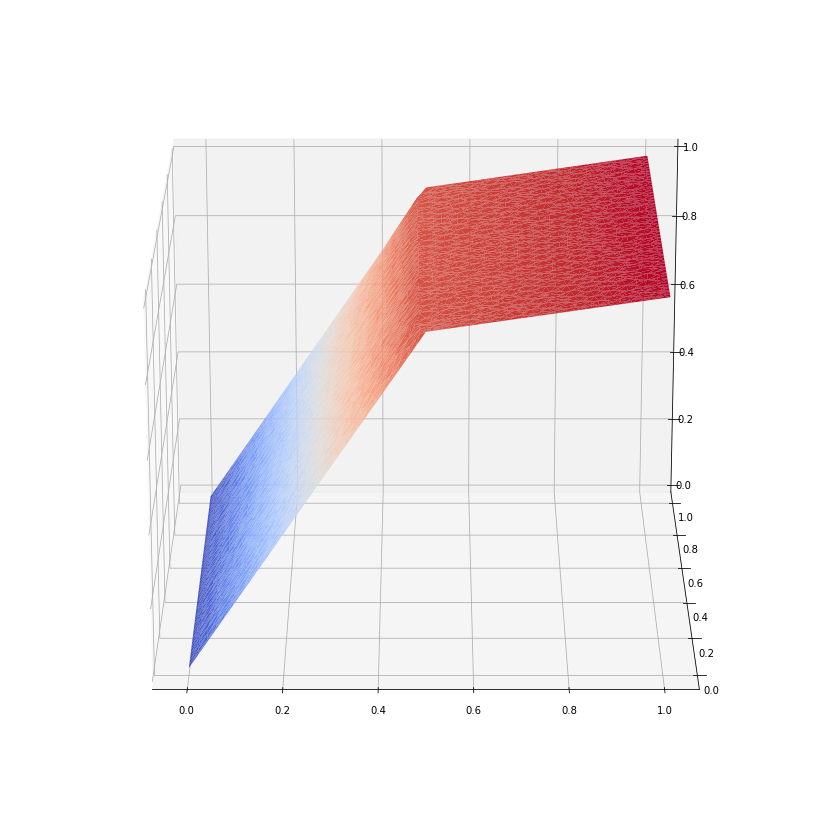

In [469]:
#visualization
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize = (15,15))
ax  = fig.add_subplot(111,projection='3d')
ax.azim = -90
ax.elev = 20.
xxx = np.array(nodes_dual)
surf = ax.plot_trisurf(xxx[:,0],
                       xxx[:,1], 
                       u, cmap=cm.coolwarm)
plt.show()

In [476]:
it

129

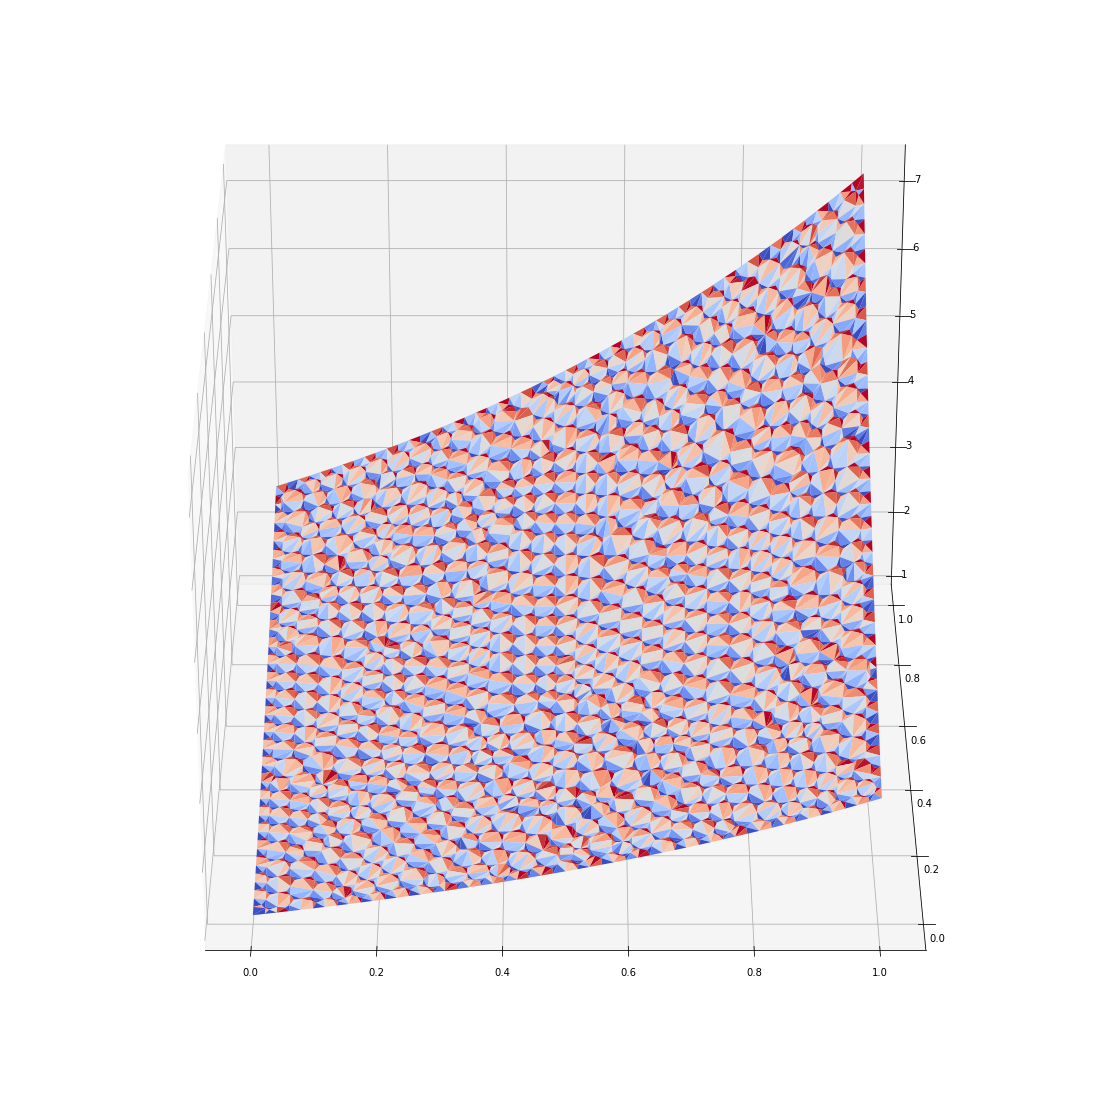

In [475]:
#try to assign a field of nodal values and look at how it is reconstructed
field = np.zeros(Nnode_dual)
for n in range(Nnode_dual):
    x,y = nodes_dual[n][0:2]
    field[n] = np.exp(x)*np.exp(y)

fig = plt.figure(figsize = (20,20))
ax  = fig.add_subplot(111, projection='3d')
ax.azim = -90. 
ax.elev = 30.
for k in range(Nnode):
    xx = np.zeros(len(cells[k]))
    yy = np.zeros(len(cells[k]))
    nodal_values = np.zeros(len(cells[k]))
    for i in range(len(cells[k])):
        xx[i], yy[i] = cells[k][i]
        nodal_values [i] = field[cells_idx[k][i]]
    reconstruction = np.dot(REC[k],nodal_values) 
    surf = ax.plot_trisurf(xx,yy, reconstruction, cmap=cm.coolwarm)